In [1]:
! pip install gurobipy

     |████████████████████████████████| 11.5 MB 3.9 MB/s 


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import gurobipy as gp

In [3]:
df=pd.read_csv('price_demand_data.csv')

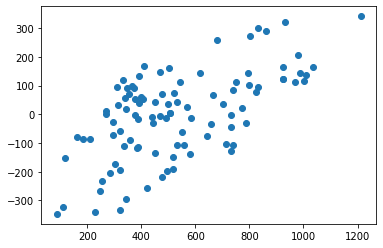

In [18]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()

lr.fit(df[['price']],df['demand'])
b0=lr.intercept_
b1=lr.coef_

plt.scatter(x=df['demand'],y=df['demand']-lr.predict(df[['price']]))

residual_arr=df['demand']-lr.predict(df[['price']])

In [22]:
estimated_demand_atPrice1=(b0+b1*1)+(residual_arr)


The profit variable for the objective function is still piece wise in nature with quantity produced and demand based decisions

With the introduction of rush hour printing price and the disposal cost only the cost prices of two partitions will change that will influence the profit variable in all the step functions.

Suppose we have selling price as p, cost price of printing newspaper is c, Optimal priniting demand is q and demand for each day/instance is di

1) When demand is less than the printed amount

The newsvendor will have to dispose off the left over quantity at 't' rate
This will increase the total cost price of generation

**Cost PRICE**

c*q+ t*(q-Di)

**Selling Price**

p*Di

**profit**
p*Di -c*q -t*(q-Di)


2) When the demand is larger than the printed papers (q)
Then the newsvendor can use rush hour priniting method priced at g>c to print the defict papers

**Cost PRICE**

c*q+ g*(Di-q)

**Selling Price**

p*Di (VEndor will get to sell as many newspaper as demanded

**profit**
p*Di -c*q- g*(Di-q)




In [25]:
# Whatever be the optimal print value the profit will remain lower than these two piecewise bounds
# We have formulated an equation that connects profit with optimal priniting quantity, this equation takes into consideration associated cost values and tries to estimate profit based on technique ceneterd around step functions

# One can try to solve for this optimal print variable by framing a optimization problem around the profit variable.
# We will try to maximise profit and from this optimization problem will detremine the decision variable associated with optimal number of prints per day

#This optimal value will be our estimate of newpaper demand

price = 1.0#Selling Price

oridinary_hour_cost = 0.5
rush_hour_cost=0.75
disposal_cost=0.15

#We have 99 sets of demand and thus we will have 99 profit values as decision variables plus one optimal printed quantity related decision variable

#Thus total number of variables will be 99+1 =100
#And total number of constraints will be 2*99 =198


In [26]:
nd=estimated_demand_atPrice1.shape[0]

obj = np.zeros(nd+1)
obj[1:] = 1.0/nd
lb = np.zeros(nd+1)
lb[1:] = -np.inf # quantity printed needs to be non-negative, but profit on a given day could possibly be negative
rhs = np.zeros(2*nd)
direction = np.array(['<']*(2*nd))


In [27]:
A = np.zeros((2*nd,nd+1))
for r in range(nd):
  #First series of profit value_stepfunction (Di>q)
  A[2*r,[0,r+1]] = [oridinary_hour_cost-rush_hour_cost,1] # location 1 is q, location r+1 is this h
  rhs[2*r] = price*estimated_demand_atPrice1[r]-oridinary_hour_cost*estimated_demand_atPrice1[r]

  #Second series of profit step function (q>Di)
  A[2*r+1,[0,r+1]] = [oridinary_hour_cost+disposal_cost,1]
  rhs[2*r+1] =  price*estimated_demand_atPrice1[r]-disposal_cost*estimated_demand_atPrice1[r]

In [33]:
spMod = gp.Model()
spMod_x = spMod.addMVar(len(obj),lb=lb) # tell the model how many variables there are
# must define the variables before adding constraints because variables go into the constraints
spMod_con = spMod.addMConstrs(A, spMod_x, direction, rhs) # NAME THE CONSTRAINTS!!! so we can get information about them later!
spMod.setMObjective(None,obj,0,sense=gp.GRB.MAXIMIZE) # add the objective to the model...we'll talk about the None and the 0

spMod.Params.OutputFlag = 0 # tell gurobi to shut up!!
spMod.optimize()


Restricted license - for non-production use only - expires 2023-10-25


In [34]:
spMod_x.x[0]

183.5032031742364